In [32]:
import json
import sys
from contextlib import suppress
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import stanza
from matplotlib import gridspec
from matplotlib.font_manager import fontManager, FontProperties

from src.constants import Criterion, Prompt, SummaryConfig, SummarizerLLM
from src.datamodel import Document
from src.util import load_data, ROOT_PATH

try:
    import summ_eval
except ImportError:
    lib_path = ROOT_PATH / 'lib' / 'SummEval' / 'evaluation'
    sys.path.append(str(lib_path))

from summ_eval.data_stats_metric import DataStatsMetric

kwargs = dict(context='paper', palette='Set1', style='darkgrid', rc={'axes.unicode_minus': False, 'text.usetex': False,})
with suppress(FileNotFoundError):
    font_path = '~/.local/share/fonts/cmunss.ttf'
    fontManager.addfont(font_path)
    prop = FontProperties(fname=font_path)
    kwargs |= dict(font=prop.get_name())
sns.set_theme(**kwargs)

# Quantitative analysis

In [33]:
def plot_metric_scatter(df, metric_x: str, metric_y: str, group_by: str = 'model', grouplabelmap: dict = None, filename: str = None):
    col_order = list(grouplabelmap.keys()) if grouplabelmap is not None else None
    g = sns.displot(data=df, col=group_by, x=metric_x, y=metric_y, hue='LANG', kind='kde', cut=0, alpha=0.7, col_order=col_order, fill=True, height=1.1, aspect=1.08, facet_kws=dict(gridspec_kws=dict(wspace=0.05)), log_scale=[True, False])
    g.set_xlabels('')
    g.set_ylabels('')

    g.set_titles('{col_name}')
    if grouplabelmap is not None:
        for ax, title in zip(g.axes.flat, g.col_names):
            if title in grouplabelmap:
                ax.set_title(grouplabelmap[title])

    legend = g.legend
    legend.set_title(None)
    handles, labels = legend.legend_handles, [t.get_text() for t in legend.texts]
    g.legend.remove()
    for handle in handles:
        if hasattr(handle, 'set_edgecolor') and hasattr(handle, 'set_alpha'):
            handle.set_edgecolor('black')
            handle.set_linewidth(0.8)
            handle.set_alpha(0.7)

    g.axes[0, 3].legend(handles, labels, loc='center', bbox_to_anchor=(0.5, 1.4), ncol=len(labels), frameon=False)

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')


def plot_metric_distributions(df, metrics: list[str], group_by: str = 'model', xticklabelmap: dict = None, filename: str = None):

    gs = gridspec.GridSpec(len(metrics), 1)
    fig = plt.figure(figsize=(7.5, 2.5))

    for i, (sp, metric) in enumerate(zip(gs, metrics)):

        ax = fig.add_subplot(sp)

        log_scale = metric in ('density', 'compression')
        order = list(xticklabelmap.keys()) if xticklabelmap else None
        sns.violinplot(data=df, x=group_by, y=metric, hue='LANG', ax=ax, cut=0, edgecolor='black', linewidth=0.5, alpha=0.7, saturation=1, split=True, gap=.1, inner='quart', log_scale=log_scale, order=order)

        if i < len(metrics) - 1:
            ax.set_xticklabels([])
        elif xticklabelmap is not None:
            ax.set_xticklabels([xticklabelmap[label.get_text()] for label in ax.get_xmajorticklabels()])

        if i == 0:
            ax.legend(bbox_to_anchor=(0.5, 1.15), loc='center', ncol=2, frameon=False)
        else:
            ax.get_legend().remove()

        if metric not in ('density', 'compression'):
            ax.set_ylim(0, 1)
        if metric == 'density':
            labels = [label.get_text() if '-' not in label.get_text() else '0.1' for label in ax.get_ymajorticklabels()]
            ax.set_yticklabels(labels, minor=False)

        ax.set_xlabel('')
        ax.set_ylabel(metric.title())

    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')


def group_stats(stats_df, by, count_key: str = None):
    count_key = count_key or ('prompt' if by == 'model' else 'model')
    grouped_df = stats_df.groupby(by).agg({
        count_key: 'count',        # Number of total entries
        'lang': 'sum',             # Number of entries that are in the correct language
        'words_per_doc': 'sum',    # Total tokens
        'tokens': get_vocabulary,  # Unique vocabulary
        'sents_per_doc': 'mean',   # Average sentences per document
    })
    grouped_df.columns = ['docs', 'lang', 'tokens', 'vocabulary', 'sents per doc']
    return grouped_df


def get_vocabulary(token_lists: list[list[str]]) -> int:
    return len(set([token for tokens in token_lists for token in eval(tokens)]))


def get_stats_df(docs: list[Document], lang: str) -> pd.DataFrame:
    nlp = stanza.Pipeline(lang=lang, processors='tokenize')
    dsm = DataStatsMetric(tokenize=False)

    records = []
    for doc in docs:

        if doc.round == 0:
            continue

        article_record = get_text_stats(nlp, dsm, 'article', 'article', doc.original_document, lang, lang)
        records.append(article_record)

        for summary in doc.reference_summaries:
            summary_record = get_text_stats(nlp, dsm, 'human', 'human', summary, lang, lang, ref=doc.original_document)
            records.append(summary_record)

        for model, summary in doc.model_summaries.items():
            if '-' not in model:
                model, prompt = 'subhead', 'subhead'
            else:
                model, prompt = model.split('-')
            if prompt.startswith('ann'):
                continue
            summary_record = get_text_stats(nlp, dsm, model, prompt, summary.summ, summary.lang, lang, ref=doc.original_document)
            records.append(summary_record)

    return pd.DataFrame.from_records(records)


def get_text_stats(nlp, dsm, model: str, prompt: str, text: str, text_lang: str, ref_lang: str, ref=None):
    analysis = nlp(text)
    tokens = []
    token_n = []
    for sent in analysis.sentences:
        token_n.append(len(sent.tokens))
        for token in sent.tokens:
            tokens.append(token.text)
    stats = dict(
        model=model,
        prompt=prompt,
        tokens=tokens,
        lang=int(text_lang == ref_lang),
        sents_per_doc=len(analysis.sentences),
        words_per_doc=len(tokens),
        words_per_sent=np.mean(token_n)
    )
    if ref is not None:
        more_stats = dsm.evaluate_example(text, ref)
        stats.update(more_stats)
    return stats


def load_or_compute_stats(data_path: Path, lang: str) -> pd.DataFrame:
    cache_file = data_path.with_suffix('.stats.csv')
    if cache_file.exists():
        df = pd.read_csv(cache_file)
    else:
        with data_path.open() as f:
            data = [Document.from_json(json.loads(line)) for line in f]
        df = get_stats_df(data, lang)
        df.to_csv(cache_file, index=False)
    return df

In [34]:
language = 'eu'
data_file = ROOT_PATH.resolve() / 'data' / language / f'BASSE.{language}.jsonl'
df_eu = load_or_compute_stats(data_file, language)
df_eu['LANG'] = language

In [35]:
language = 'es'
data_file = ROOT_PATH.resolve() / 'data' / language / f'BASSE.{language}.jsonl'
df_es = load_or_compute_stats(data_file, language)
df_es['LANG'] = language

In [36]:
df = pd.concat([df_eu, df_es], ignore_index=True)

In [37]:
results_path = ROOT_PATH / 'results' / 'corpus'
results_path.mkdir(parents=True, exist_ok=True)

In [38]:
model_stats_df = group_stats(df, ['LANG', 'model'])

with (results_path / 'stats-by-author.tex').open('w') as wf:
    wf.write(model_stats_df.to_latex(float_format='%.0f'))

model_stats_df

docs  lang  tokens  vocabulary  sents per doc
LANG model                                                  
es   article     45    45   38551        8200      30.400000
     claude     180   154   32301        6226       9.672222
     commandr   180   179   30460        4724       6.811111
     gpt4o      180   180   29647        4962       7.205556
     human       75    75   11635        3180       4.946667
     llama3     180   180   33918        4401       7.805556
     reka       180   180   32619        4858       7.116667
     subhead     45    45    1040         578       1.200000
eu   article     45    45   22862        7328      33.977778
     claude     180   142   29602        7589      12.405556
     commandr   180   164   37236        7945      13.483333
     gpt4o      180   180   30859        7235      12.361111
     human       75    75    8867        3428       5.706667
     llama3     180   180   14671        3279       6.422222
     reka       180   180   21387        4658       7.116667
     subhead     45    45    1562         927       3.044444

In [39]:
prompt_stats_df = group_stats(df, ['LANG', 'prompt'])

with (results_path / 'stats-by-prompt.tex').open('w') as wf:
    wf.write(prompt_stats_df.to_latex(float_format='%.0f'))

prompt_stats_df

docs  lang  tokens  vocabulary  sents per doc
LANG prompt                                                
es   5w1h      225   225   49885        5625      10.448889
     article    45    45   38551        8200      30.400000
     base      225   225   42242        5836       8.000000
     core      225   225   36059        5349       6.617778
     human      75    75   11635        3180       4.946667
     subhead    45    45    1040         578       1.200000
     tldr      225   198   30759        6099       5.822222
eu   5w1h      225   225   37273        6740      15.102222
     article    45    45   22862        7328      33.977778
     base      225   203   43452        9965      11.875556
     core      225   225   24746        5378       7.177778
     human      75    75    8867        3428       5.706667
     subhead    45    45    1562         927       3.044444
     tldr      225   193   28284        7483       7.275556

In [40]:
llm_df = df[~df['prompt'].isin(['article', 'human', 'subhead'])]
llm_stats_df = group_stats(llm_df, ['LANG'])

with (results_path / 'stats-by-llm.tex').open('w') as wf:
    wf.write(llm_stats_df.to_latex(float_format='%.0f'))

llm_stats_df

,docs,lang,tokens,vocabulary,sents per doc
LANG,,,,,
es,900,873,158945,10844,7.722222
eu,900,846,133755,15755,10.357778


In [41]:
df = df[['model', 'prompt', 'LANG', 'coverage', 'density', 'compression', 'percentage_novel_2-gram']]
df.columns = ['model', 'prompt', 'LANG', 'coverage', 'density', 'compression', 'novel 2-gram']
df = df[df['model'] != 'article']

/tmp/ipykernel_12353/4081434534.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xticklabelmap[label.get_text()] for label in ax.get_xmajorticklabels()])


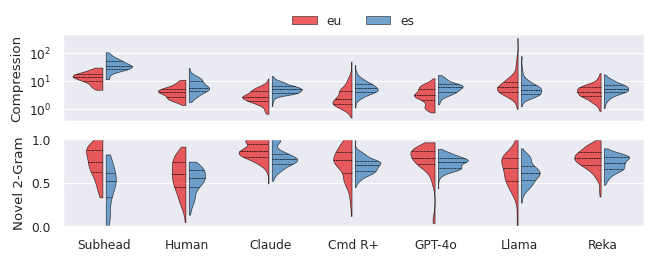

In [42]:
label_map = {
    'subhead': 'Subhead',
    'human': 'Human',
    SummarizerLLM.claude: 'Claude',
    SummarizerLLM.command_r: 'Cmd R+',
    SummarizerLLM.gpt_4o: 'GPT-4o',
    SummarizerLLM.llama_3: 'Llama',
    SummarizerLLM.reka: 'Reka'
}
file_path = results_path / 'stats-by-author.violinplot.pdf'
plot_metric_distributions(df, ['compression', 'novel 2-gram'], group_by='model', xticklabelmap=label_map, filename=str(file_path))

/home/nperez/.venv/summeu/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/nperez/.venv/summeu/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


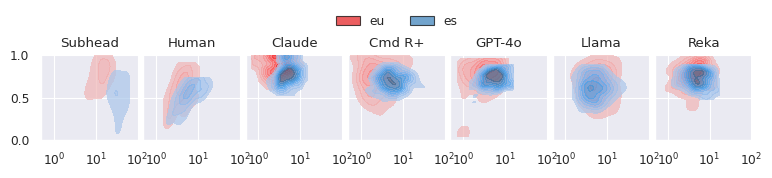

In [43]:
file_path = results_path / 'stats-by-author.kde.pdf'
plot_metric_scatter(df, 'compression', 'novel 2-gram', 'model', grouplabelmap=label_map, filename=str(file_path))

/tmp/ipykernel_12353/4081434534.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([xticklabelmap[label.get_text()] for label in ax.get_xmajorticklabels()])


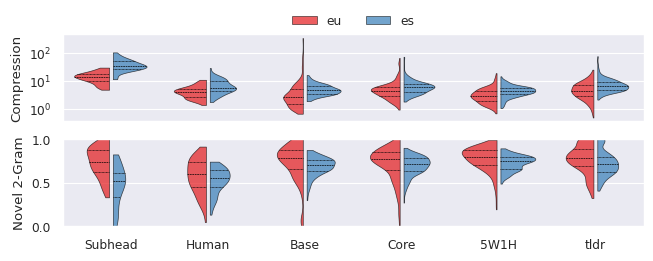

In [44]:
label_map = {
    'subhead': 'Subhead',
    'human': 'Human',
    Prompt.base: 'Base',
    Prompt.core: 'Core',
    Prompt.wh: '5W1H',
    Prompt.tldr: 'tldr'
}
file_path = results_path / 'stats-by-prompt.violinplot.pdf'
plot_metric_distributions(df, ['compression', 'novel 2-gram'], group_by='prompt', xticklabelmap=label_map, filename=str(file_path))

# Qualitative analysis

In [45]:
def get_averages(data: list[Document], summary_key: str, model: str, prompt: str):
	result = {'model': model, 'prompt': prompt}
	total = 0
	for criterion in list(Criterion):
		anns = [np.average(doc.model_summaries[summary_key].anns[criterion]) for doc in data]
		avg = np.array(anns).mean()
		result[criterion] = avg
		total += avg
	result['avg.'] = total / 5
	return result

def to_dataframe(data: list[Document]):
    model_data = []
    # Human summary quality
    for human in ('human-ann1', 'human-ann2', 'human-ann3'):
        example = get_averages(data[:15], human, human, 'None')
        model_data.append(example)
    # Baseline summary (=subhead) quality
    example = get_averages(data, 'subhead', 'subhead', 'None')
    model_data.append(example)
    # LLM-generated summary quality
    for summary_config in list(SummaryConfig):
        model, prompt = summary_config.split('-')
        example = get_averages(data, summary_config, model, prompt)
        model_data.append(example)
    return pd.DataFrame(model_data)

## Spanish

In [46]:
data = load_data('es')
es_quality_df = to_dataframe(data)

es_quality_df

,model,prompt,Coherence,Consistency,Fluency,Relevance,5W1H,avg.
0,human-ann1,None,4.900000,4.933333,5.000000,4.800000,4.233333,4.773333
1,human-ann2,None,5.000000,4.966667,4.933333,4.133333,4.833333,4.773333
2,human-ann3,None,4.833333,4.733333,4.466667,4.500000,3.966667,4.500000
3,subhead,None,4.600000,4.851852,4.933333,4.318519,2.014815,4.143704
4,claude,base,3.429630,4.725926,4.962963,3.859259,4.340741,4.263704
5,claude,core,3.585185,4.814815,4.955556,3.814815,4.207407,4.275556
6,claude,5w1h,2.666667,4.585185,4.977778,3.800000,4.762963,4.158519
7,claude,tldr,3.000000,4.703704,2.688889,3.777778,4.296296,3.693333
8,commandr,base,4.437037,4.614815,4.918519,4.170370,4.074074,4.442963
9,commandr,core,4.488889,4.637037,4.970370,4.437037,3.451852,4.397037


In [47]:
with (results_path / f'summary-quality.es.tex').open('w') as wf:
    wf.write(es_quality_df.to_latex(index=False, float_format='%.2f'))

## Basque

In [48]:
data = load_data('eu')
es_quality_df = to_dataframe(data)

es_quality_df

,model,prompt,Coherence,Consistency,Fluency,Relevance,5W1H,avg.
0,human-ann1,None,4.900000,5.000000,5.000000,4.600000,4.866667,4.873333
1,human-ann2,None,4.733333,4.933333,4.966667,4.066667,4.966667,4.733333
2,human-ann3,None,4.666667,4.900000,4.566667,4.866667,4.233333,4.646667
3,subhead,None,3.696296,4.785185,4.970370,4.555556,2.800000,4.161481
4,claude,base,3.200000,4.711111,3.133333,3.037037,4.600000,3.736296
5,claude,core,3.733333,4.570370,4.466667,3.762963,4.296296,4.165926
6,claude,5w1h,2.511111,4.362963,4.614815,3.451852,4.851852,3.958519
7,claude,tldr,3.244444,4.800000,3.103704,3.918519,4.525926,3.918519
8,commandr,base,3.251852,3.311111,2.496296,2.792593,3.748148,3.120000
9,commandr,core,2.562963,3.881481,2.822222,2.777778,2.785185,2.965926


In [49]:
with (results_path / f'summary-quality.eu.tex').open('w') as wf:
    wf.write(es_quality_df.to_latex(index=False, float_format='%.2f'))